# Análisis de Serie Temporal Meteorológica (Alicante) / "predicción días de viento"

La propuesta de este trabajo responde a la necesidad de conocer los días de mayor actividad eólica con el fin de optimizar la producción de energía eléctrica. En concreto, se pretende evitar la sobreproducción de esta
por las vias tradiccionales, debido al aumento de la generación eólica. Asi además, como beneficio colateral, evitamos almacenar grandes cantidades de energía ya que el almacenamiento siempre supone péridas.

<img src="https://graffica.info/wp-content/uploads/aemet-noruega1.png" title="AEMET Logo"/>

>El dataset usado es proporcionado por las estaciones meteorológicas de AEMET. 
Este presenta el registro histórico de los siguientes campos:
***
1. Columna1: Fecha en formato (aaaa-mm-dd) . Si lo abre con una hoja de cálculo, es posible que interprete el  campo como fecha y lo vea en el formato habitual dd/mm/aaaa
2. Columna2: Identificador de Estación Meteorológica (Valor de 4 a 5 caracteres)
3. Columna3: Nombre de la Estación
4. Columna4: Provincia en la que se encuentra
5. Columna5: Altitud (metros) sobre el nivel del mar
6. Columna6: Temperatura media diaria (ºC)
7. Columna7: Precipitación diaria de 07h a 07h (mm = l/m2) 
8. Columna8: Temperatura minima del día(ºC)
9. Columna9: Hora de Temperatura mínima (hh:mm UTC)
10. Columna10: Temperatura Máxima (ºC)
11. Columna11: Hora de Temperatura máxima (hh:mm UTC)
12. Columna12: Dirección de la racha máxima (decenas de grado)
13. Columna13: Velocidad media del viento (m/s)
14. Columna14: Racha máxima de viento (m/s)
15. Columna15: Hora y minuto Racha máxima de viento (hh:mm UTC) 
16. Columna16: Horas de Sol (horas)
17. Columna17: Presión máxima al nivel de referencia de la estación (hPa)
18. Columna18: Hora de la presiín máxima (redondeada a la hora entera más próxima) (hora)
19. Columna19: Presión mínima al nivel de referencia de la estación (hPa)
20. Columna20: Hora de la presión mínima (redondeada a la hora entera más próxima) (hora)


In [2]:
# Importamos Librerias necesarias
#=============================================================
import pandas as pd 
import os 
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
from sty import fg, bg, ef, rs
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm 

#Logger
#=============================================================================
import logging
import coloredlogs

#coloredlogs.install(level='DEBUG')
#logging.basicConfig(filename='meteo.log', encoding='utf-8', level=logging.INFO)
#logger = logging.getLogger('meteo')
#logger.info("Configurando Logger")

# Modelado y Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

#=================Config Plot====================

plt.style.use('fivethirtyeight') 
plt.rcParams["figure.figsize"] = 16,9
##plt.rc('text', usetex=True)
plt.rc('font', family='serif')



#=================Apuntes Colores Terminal====================
#foo = fg.red + 'This is red text!' + fg.rs
#bar = bg.blue + 'This has a blue background!' + bg.rs
#baz = ef.italic + 'This is italic text' + rs.italic
#qux = fg(201) + 'This is pink text using 8bit colors' + fg.rs
#qui = fg(255, 10, 10) + 'This is red text using 24bit colors.' + fg.rs


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

### Colores de matplotlib
<div>
<img src="img/colors.png" width="600">
</div>

In [3]:
# Configuración Directorios relativos
# ===========================================================

data_folder = 'data/MeteoSpaData'
work_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(work_dir, os.pardir))
data_dir = os.path.join(parent_dir,data_folder)
estaciones_file= os.path.join(data_dir,'ListadoEstaciones-20190206.xlsx')
print(data_dir)

d:\[3]--Python Workdir--[3]\data/MeteoSpaData


In [4]:
# Carga de los datos de las estaciones meteorológicas
#=============================================================

df_estaciones = pd.read_excel(estaciones_file, engine='openpyxl',index_col=None, header=None)
df_estaciones.columns=['ID_Estación','ID','Localización','Provincia','Coordenada_Norte','Coordenada_Oeste','Altura']
df_estaciones['Coordenada_Norte'] = df_estaciones['Coordenada_Norte'].str.replace('N','')
df_estaciones['Coordenada_Oeste'] = df_estaciones['Coordenada_Oeste'].str.replace('W','')
df_estaciones.head(3)

,ID_Estación,ID,Localización,Provincia,Coordenada_Norte,Coordenada_Oeste,Altura
0,1387E,8002.0,A CORUÑA AEROPUERTO,A CORUÑA,431825,082219,98
1,1387,8001.0,A CORUÑA,A CORUÑA,432157,082517,58
2,1393,8006.0,CABO VILAN,A CORUÑA,430938,091239,50


In [5]:
# Función para pasar de grados minutos segundos a gradosº
#=============================================================
def dms_dd(degrees, minutes, seconds):
    decimal = 0.0
    if (degrees >= 0):
        decimal = degrees + float(minutes)/60 + float(seconds)/3600
    else:
        decimal = degrees - float(minutes)/60 - float(seconds)/3600
    return decimal

In [6]:
w = df_estaciones['Coordenada_Oeste'].str.extract('(.{2})(.{2})(.{2})').astype(int)
n = df_estaciones['Coordenada_Norte'].str.extract('(.{2})(.{2})(.{2})').astype(int)

df_estaciones['Latitud'] = n.apply(lambda x: dms_dd(x[0],x[1],x[2]), axis=1)
df_estaciones['Longitud'] = w.apply(lambda x: dms_dd(x[0],x[1],x[2]), axis=1)

df_estaciones.head(3)

,ID_Estación,ID,Localización,Provincia,Coordenada_Norte,Coordenada_Oeste,Altura,Latitud,Longitud
0,1387E,8002.0,A CORUÑA AEROPUERTO,A CORUÑA,431825,082219,98,43.306944,8.371944
1,1387,8001.0,A CORUÑA,A CORUÑA,432157,082517,58,43.365833,8.421389
2,1393,8006.0,CABO VILAN,A CORUÑA,430938,091239,50,43.160556,9.210833


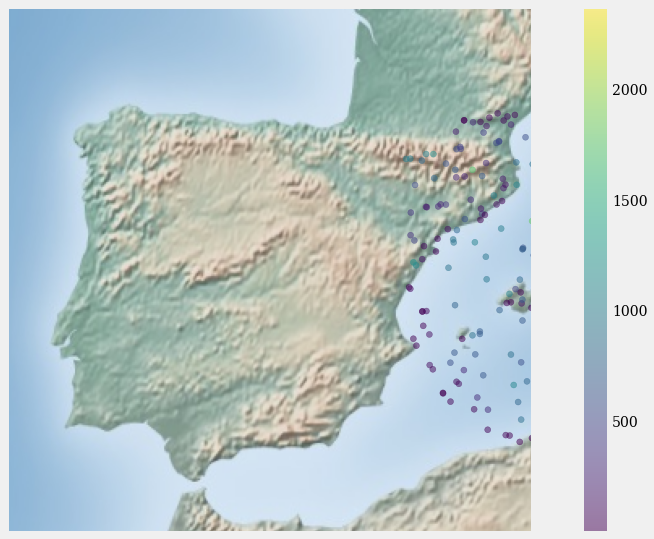

In [7]:
# Graficamos las estaciones para ver las que nos pueden interesar con su respectiva altura
#==============================================================================================
# Extract the data we're interested in
lat, lon, alt = df_estaciones['Latitud'], df_estaciones['Longitud'],df_estaciones['Altura']

mean_latitude = lat.mean()
mean_longitude = lon.mean()

fig = plt.figure(figsize=(16,9))
m = Basemap(projection='lcc', lat_0= 40.41831,lon_0 = -3.70275, width=1.2e6, height=1.2e6, resolution='l')
m.shadedrelief()
m.scatter(
    df_estaciones.Longitud.values, df_estaciones.Latitud.values,
    c = df_estaciones.Altura.values, alpha = 0.5,
    latlon = True);
plt.colorbar();

In [7]:
df_estaciones[df_estaciones['Provincia']=='ALICANTE'].head(15)

,ID_Estación,ID,Localización,Provincia,Coordenada_Norte,Coordenada_Oeste,Altura,Latitud,Longitud
13,8025,8359.0,ALICANTE/ALACANT,ALICANTE,382221,002939,81,38.372500,0.494167
14,8019,8360.0,ALICANTE-ELCHE AEROPUERTO,ALICANTE,381658,003415,43,38.282778,0.570833
15,8050X,8370.0,JÁVEA/ XÀBIA,ALICANTE,384701,001004E,15,38.783611,0.167778
16,7247X,8357.0,PINOSO,ALICANTE,382359,010217,575,38.399722,1.038056


## Análisis de la estación de Interés (Alicante)

In [7]:
#Cargamos los datos de la estación de interés
#===================================================================
file = os.path.join(data_dir,'8025-19380901-20220103.csv')
df = pd.read_csv(file, sep=';')
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y-%m-%d')

print('Fecha_min  -----> '+fg.green+ str(df['FECHA'].max())+ fg.rs)
print('Fecha_max  -----> '+fg.green+ str(df['FECHA'].min()))

df = df.set_index('FECHA')
df.sort_index()
df = df.asfreq('1d')
df.head(100)


Fecha_min  -----> 2022-01-03 00:00:00
Fecha_max  -----> 1938-09-01 00:00:00


,INDICATIVO,NOMBRE,PROVINCIA,ALTITUD,TMEDIA,PRECIPITACION,TMIN,HORATMIN,TMAX,HORATMAX,DIR,VELMEDIA,RACHA,HORARACHA,SOL,PRESMAX,HORAPRESMAX,PRESMIN,HORAPRESMIN
FECHA,,,,,,,,,,,,,,,,,,,
1938-09-01,8025.0,ALICANTE/ALACANT,ALICANTE,81.0,23.3,0.0,18.6,06:00,28.0,13:05,NaN,4.7,NaN,NaN,11.2,1006.6,10,1005.1,20
1938-09-02,8025.0,ALICANTE/ALACANT,ALICANTE,81.0,22.7,Ip,18.1,04:30,27.3,11:30,9.0,6.4,11.1,13:08,6.8,1006.2,11,1003.2,17
1938-09-03,8025.0,ALICANTE/ALACANT,ALICANTE,81.0,24.2,1.9,21.1,04:20,27.2,13:45,5.0,3.3,9.4,19:12,4.6,1008.6,24,1003.2,01
1938-09-04,8025.0,ALICANTE/ALACANT,ALICANTE,81.0,22.7,0.0,18.6,05:30,26.8,13:40,14.0,4.7,8.3,11:27,10.8,1011.1,10,1008.4,01
1938-09-05,8025.0,ALICANTE/ALACANT,ALICANTE,81.0,23.4,0.0,19.8,05:45,27.1,12:00,14.0,3.3,6.9,12:30,8.3,1010.2,01,1007.4,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938-12-05,8025.0,ALICANTE/ALACANT,ALICANTE,81.0,18.0,0.0,11.5,NaN,24.6,NaN,NaN,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1938-12-06,8025.0,ALICANTE/ALACANT,ALICANTE,81.0,18.2,0.0,13.4,NaN,23.0,NaN,NaN,6.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1938-12-07,8025.0,ALICANTE/ALACANT,ALICANTE,81.0,15.3,0.0,9.3,NaN,21.3,NaN,NaN,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.fillna(0)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30441 entries, 1938-09-01 to 2022-01-03
Freq: D
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   INDICATIVO     30429 non-null  float64
 1   NOMBRE         30429 non-null  object 
 2   PROVINCIA      30429 non-null  object 
 3   ALTITUD        30429 non-null  float64
 4   TMEDIA         30344 non-null  float64
 5   PRECIPITACION  30416 non-null  object 
 6   TMIN           30346 non-null  float64
 7   HORATMIN       30280 non-null  object 
 8   TMAX           30347 non-null  float64
 9   HORATMAX       30285 non-null  object 
 10  DIR            21914 non-null  float64
 11  VELMEDIA       30363 non-null  float64
 12  RACHA          21914 non-null  float64
 13  HORARACHA      21909 non-null  object 
 14  SOL            30294 non-null  float64
 15  PRESMAX        29917 non-null  float64
 16  HORAPRESMAX    29915 non-null  object 
 17  PRESMIN        29916 non-

In [9]:
df.isnull()

,INDICATIVO,NOMBRE,PROVINCIA,ALTITUD,TMEDIA,PRECIPITACION,TMIN,HORATMIN,TMAX,HORATMAX,DIR,VELMEDIA,RACHA,HORARACHA,SOL,PRESMAX,HORAPRESMAX,PRESMIN,HORAPRESMIN
FECHA,,,,,,,,,,,,,,,,,,,
1938-09-01,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False
1938-09-02,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1938-09-03,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1938-09-04,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1938-09-05,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2021-12-31,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2022-01-01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Con el objetivo de poder entrenar los modelos, hacer búsqueda de los mejores hiperparámetros y, finalmente, evaluar su capacidad predictiva, se reparten los datos en tres conjuntos: entrenamiento, validación y test.

In [10]:
fin_train = '1999-12-31 00:00:00'
fin_validacion = '2009-12-31 00:00:00'
df_train = df.loc[: fin_train, :]
df_val   = df.loc[fin_train:fin_validacion, :]
df_test  = df.loc[fin_validacion:, :]

> Hay que ver si la series esta completa para poder trabajar con ella 

In [11]:
# Verificar validez índice temporal
# ==============================================================================
(df.index == pd.date_range(start=df.index.min(),
                              end=df.index.max(),
                              freq=df.index.freq)).all()

# Completar huecos en un índice temporal
# ==============================================================================
# datos.asfreq(freq='30min', fill_value=np.nan)

True

### Análisis Gráfico

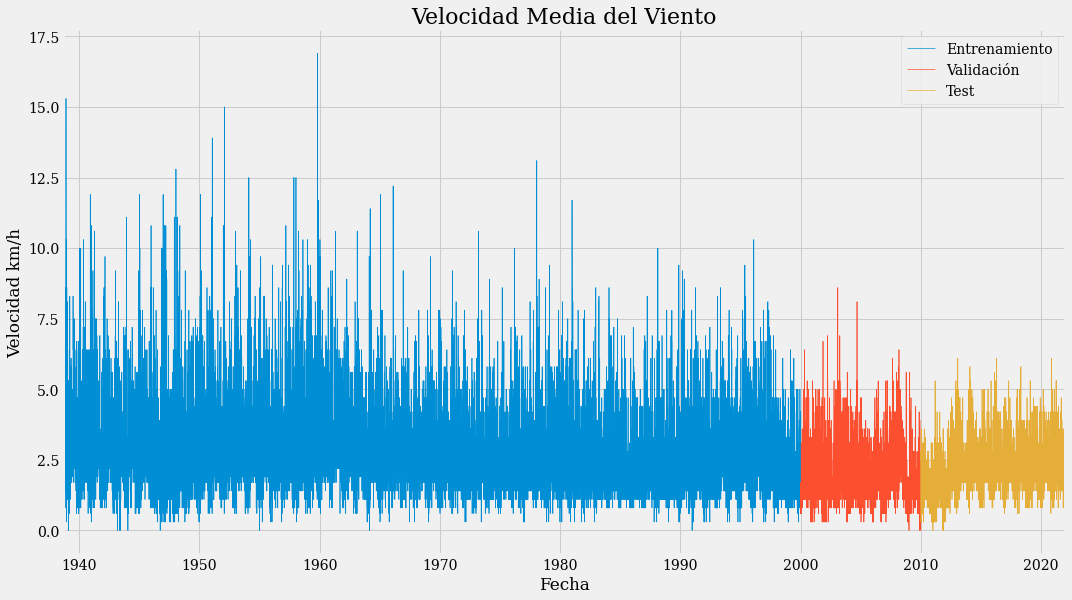

In [12]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(16, 9))
df_train['VELMEDIA'].plot(ax=ax, label='Entrenamiento', linewidth=0.7)
df_val['VELMEDIA'].plot(ax=ax, label='Validación',linewidth=0.7)
df_test['VELMEDIA'].plot(ax=ax, label='Test',linewidth=0.7)
ax.set_title('Velocidad Media del Viento', fontsize =22)
ax.set_ylabel('Velocidad km/h')
ax.set_xlabel('Fecha')
ax.legend()

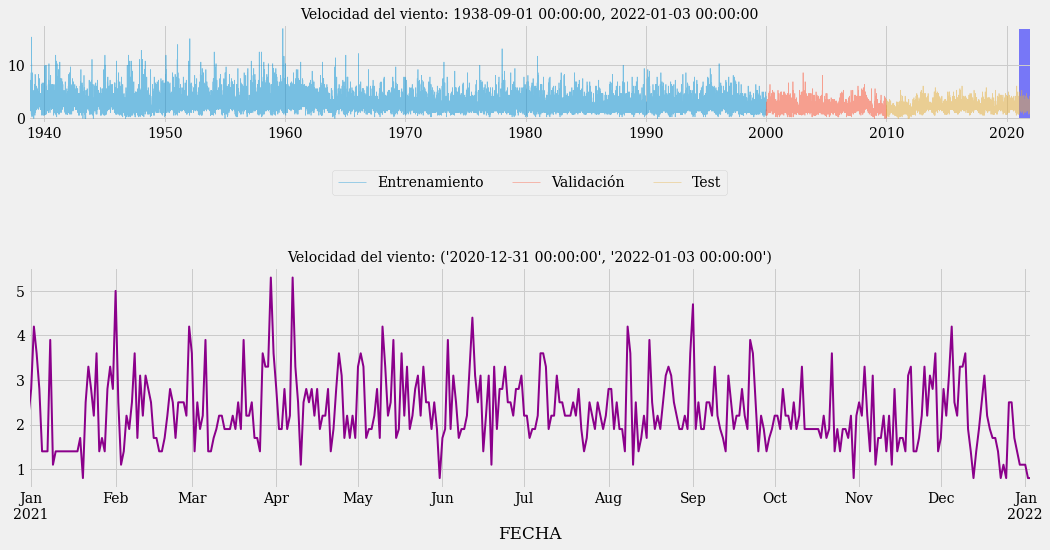

In [13]:
##Función para plotear una sección de la serie temporal 
# =============================================================
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
zoom = ('2020-12-31 00:00:00','2022-01-03 00:00:00')

fig = plt.figure(figsize=(16, 9))
grid = plt.GridSpec(nrows=9, ncols=1, hspace=0.6, wspace=0)
#fig.suptitle('Zoom a un rango de Fechas de la Serie', fontsize=16)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

df_train['VELMEDIA'].plot(ax=main_ax, label='Entrenamiento', linewidth=0.7, alpha=0.5)   #, c='black' 
df_val['VELMEDIA'].plot(ax=main_ax, label='Validación',linewidth=0.7, alpha=0.5)         #Para color gris
df_test['VELMEDIA'].plot(ax=main_ax, label='Test',linewidth=0.7, alpha=0.5)
min_y = min(df['VELMEDIA'])
max_y = max(df['VELMEDIA'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))

df.loc[zoom[0]: zoom[1]]['VELMEDIA'].plot(ax=zoom_ax, color='darkmagenta', linewidth=2)

main_ax.set_title(f'Velocidad del viento: {df.index.min()}, {df.index.max()}', fontsize=14)
zoom_ax.set_title(f'Velocidad del viento: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)


In [18]:
df.loc[:fin_train, 'particion'] = 'entrenamiento'
df.loc[fin_train:fin_validacion, 'particion'] = 'validación'
df.loc[fin_validacion:, 'particion'] = 'test'

fig = px.line(
    data_frame = df.reset_index(),
    x      = 'FECHA',
    y      = 'VELMEDIA',
    color  = 'particion',
    title  = 'Velocidad Media del Viento',
    width  = 900,
    height = 500
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

df = df.drop(columns='particion')

## Análisis técnico

### Gráfico Autocorrelación

> La autocorrelación o dependencia secuencial es una característica que consiste en que, elementos cercanos en el espacio o en el tiempo se parecen más entre sí que con respecto a elementos más lejanos, solamente por el hecho de estar cerca

En definitiva es la diferencia de losv valores esperados de la variable desplazada un LAG

 El valor esperado a su vez nos indica el valor hacía el que tiende la media de una variable aleatoria cuando el número de muestras tiende a infinito

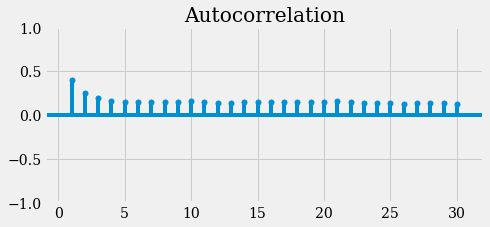

In [15]:
# Gráfico autocorrelación
# ==============================================================================
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(df.VELMEDIA.dropna(), ax=ax, lags=30, zero= False, alpha=0.9)
plt.show()
#df['VELMEDIA'].values.squeeze() #df.VELMEDIA.diff().dropna()


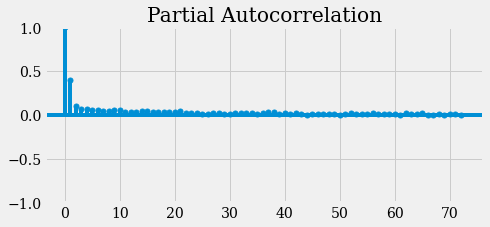

In [16]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(df['VELMEDIA'].dropna(), ax=ax, lags=72, method='ywm', alpha= 0.5)
plt.show()

In [ ]:
#x = pd.plotting.autocorrelation_plot(df['VELMEDIA'].dropna()) 
#x.plot(grid=True) 
#plt.show()

### Descomposición en componentes
<div>
<img src="img/descomposicion.png" width="600">
</div>

El método para hacer la descomposición es en definitiva un ajuste por mínimos cuadrados y vemos si hay relación entre T y t en distintos intervalos.
<div>
<img src="img/metododesc.png" width="600">
</div>

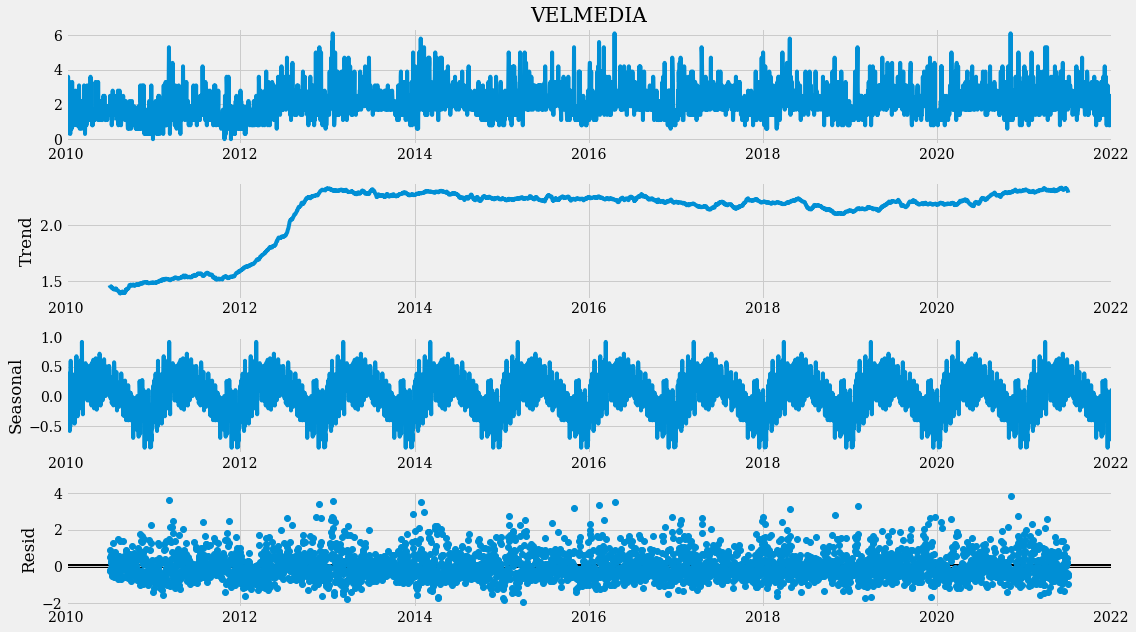

In [17]:
descomposicion = sm.tsa.seasonal_decompose(df_test.VELMEDIA.dropna(),model='additive',period=365)  
fig = descomposicion.plot()

#model= 'multiplicative'

### Desplazando los valores de la serie

In [18]:
# desplazando en 1 dia el valor de cierre
df_shifted= df['VELMEDIA'].shift(30)

# calculando el porcentaje de variación del día.
variacion_mensual = df['VELMEDIA'] / df['VELMEDIA'].shift(30) - 1
variacion_mensual

FECHA
1938-09-01         NaN
1938-09-02         NaN
1938-09-03         NaN
1938-09-04         NaN
1938-09-05         NaN
                ...   
2021-12-30   -0.214286
2021-12-31   -0.352941
2022-01-01   -0.607143
2022-01-02   -0.636364
2022-01-03   -0.741935
Freq: D, Name: VELMEDIA, Length: 30441, dtype: float64

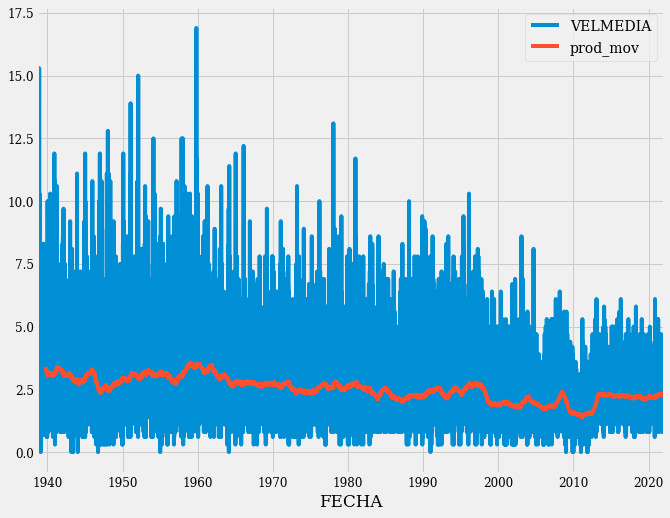

In [19]:
# Calculando promedios móviles cada 5 días
media_movil_365 = df['VELMEDIA'].dropna().rolling(365).mean()
df['prod_mov'] = media_movil_365
plot = df[['VELMEDIA', 'prod_mov']].plot(figsize=(10, 8), fontsize=12)

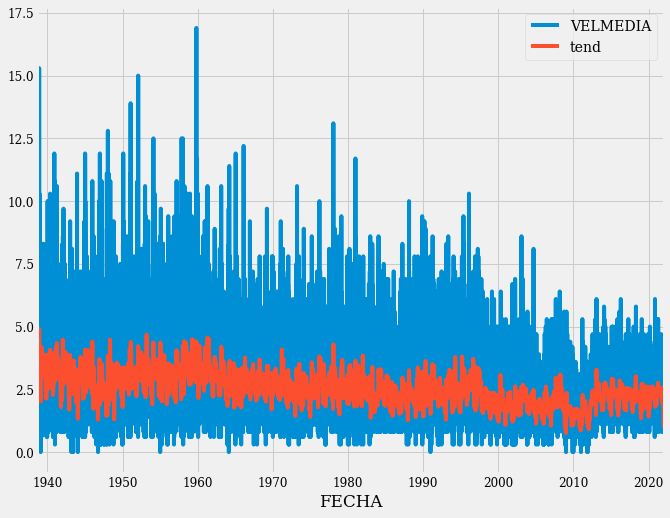

In [20]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
df_ciclo, df_tend = sm.tsa.filters.hpfilter(df['VELMEDIA'].dropna())
df['tend'] = df_tend
df['ciclo'] = df_ciclo
# graficando la variacion del precio real con la tendencia.
df[['VELMEDIA', 'tend']].plot(figsize=(10, 8), fontsize=12)
legend = plt.legend()
legend.prop.set_size(14)

Text(0.5, 0.98, '')

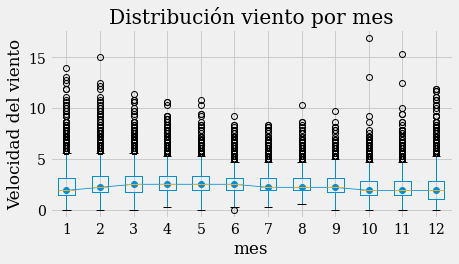

In [ ]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
df['mes'] = df.index.month
df.boxplot(column='VELMEDIA', by='mes', ax=ax,)
df.groupby('mes')['VELMEDIA'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Velocidad del viento')
ax.set_title('Distribución viento por mes')
fig.suptitle('')

Text(0.5, 0.98, '')

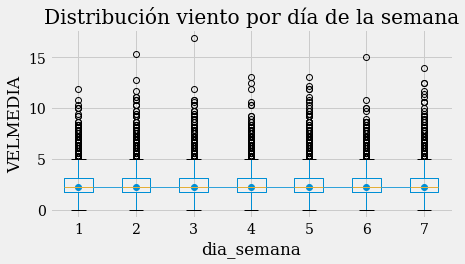

In [ ]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
df['dia_semana'] = df.index.day_of_week + 1
df.boxplot(column='VELMEDIA', by='dia_semana', ax=ax)
df.groupby('dia_semana')['VELMEDIA'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('VELMEDIA')
ax.set_title('Distribución viento por día de la semana')
fig.suptitle('')

>Mientras se puede ver alguna variación dependiente del mes, no es así respecto al día de la semana.

In [21]:
df


,INDICATIVO,NOMBRE,PROVINCIA,ALTITUD,TMEDIA,PRECIPITACION,TMIN,HORATMIN,TMAX,HORATMAX,DIR,VELMEDIA,RACHA,HORARACHA,SOL,PRESMAX,HORAPRESMAX,PRESMIN,HORAPRESMIN
FECHA,,,,,,,,,,,,,,,,,,,
1938-09-01,8025.0,ALICANTE/ALACANT,ALICANTE,81.0,23.3,0.0,18.6,06:00,28.0,13:05,NaN,4.7,NaN,NaN,11.2,1006.6,10,1005.1,20
1938-09-02,8025.0,ALICANTE/ALACANT,ALICANTE,81.0,22.7,Ip,18.1,04:30,27.3,11:30,9.0,6.4,11.1,13:08,6.8,1006.2,11,1003.2,17
1938-09-03,8025.0,ALICANTE/ALACANT,ALICANTE,81.0,24.2,1.9,21.1,04:20,27.2,13:45,5.0,3.3,9.4,19:12,4.6,1008.6,24,1003.2,01
1938-09-04,8025.0,ALICANTE/ALACANT,ALICANTE,81.0,22.7,0.0,18.6,05:30,26.8,13:40,14.0,4.7,8.3,11:27,10.8,1011.1,10,1008.4,01
1938-09-05,8025.0,ALICANTE/ALACANT,ALICANTE,81.0,23.4,0.0,19.8,05:45,27.1,12:00,14.0,3.3,6.9,12:30,8.3,1010.2,01,1007.4,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30,8025.0,ALICANTE/ALACANT,ALICANTE,81.0,14.6,0.0,7.9,07:30,21.3,12:20,14.0,1.1,4.2,14:00,8.9,1015.6,23,1013.0,04
2021-12-31,8025.0,ALICANTE/ALACANT,ALICANTE,81.0,11.8,0.0,6.0,06:40,17.7,13:50,18.0,1.1,3.3,11:50,7.9,1018.9,21,1014.8,05
2022-01-01,8025.0,ALICANTE/ALACANT,ALICANTE,81.0,12.0,0.0,6.6,23:59,17.5,13:50,14.0,1.1,4.2,14:00,8.8,1019.8,Varias,1017.7,14


La conclusión que podemos extraer aquí es que por ejemplo en la última década la tendencia general ha sido creciente y se puede observar una estacionalidad anual bastante pronunciada como para tenerla en cuenta.

# XGBoost


XGBoost, acrónimo de Extreme Gradient Boosting es una implementación muy eficiente del algoritmo de stochastic gradient boosting que se ha convertido en un referente dentro del ámbito de machine learning. Además de su propia API, la librería XGBoost incluye la clase XGBRegressor que sigue la API de scikit learn y, por lo tanto, es compatible con skforecast.

Como primera aproximación se utiliza un modelo autorregresivo que utiliza como predictores valores pasados (lags) de la propia variable respuesta. Dada la elevada cantidad de hiperparámetros que tienen los modelos de gradient boosting, se emplea una estrategia de gridsearch combinada con backtesting para identificar la configuración con la que se obtienen mejores predicciones.

In [21]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 30
             )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window size: 30 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Re

- **eta [default=0.3, alias: learning_rate]**

  - It is analogous to learning rate in GBM.
  - It is the step size shrinkage used in update to prevent overfitting. 
  - After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
  - It makes the model more robust by shrinking the weights on each step.
  - range : [0,1]
  - Typical final values : 0.01-0.2.

&nbsp;

- **max_depth [default=6]**

    - The maximum depth of a tree, same as GBM.
    - It is used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
    - Increasing this value will make the model more complex and more likely to overfit. 
    - The value 0 is only accepted in lossguided growing policy when tree_method is set as hist and it indicates no limit on depth. 
    - We should be careful when setting large value of max_depth because XGBoost aggressively consumes memory when training a deep tree.
    - range: [0,∞] (0 is only accepted in lossguided growing policy when tree_method is set as hist.
    - Should be tuned using CV.
    - Typical values: 3-10

&nbsp;

- **min_child_weight [default=1]**

   - It defines the minimum sum of weights of all observations required in a child.
   - This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
   - It is used to control over-fitting. 
   - Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
   - Too high values can lead to under-fitting. 
   - Hence, it should be tuned using CV.
   - The larger min_child_weight is, the more conservative the algorithm will be.
   - range: [0,∞]

&nbsp;

- **max_delta_step [default=0]**

   - In maximum delta step we allow each tree’s weight estimation to be. 
   - If the value is set to 0, it means there is no constraint. 
   - If it is set to a positive value, it can help making the update step more conservative.
   - Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced.
   - Set it to value of 1-10 might help control the update.
   - range: [0,∞]

&nbsp;

- **subsample [default=1]**

   - It denotes the fraction of observations to be randomly samples for each tree.
   - Subsample ratio of the training instances. 
   - Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees.      - This will prevent overfitting. 
   - Subsampling will occur once in every boosting iteration.
   - Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
   - Typical values: 0.5-1
   - range: (0,1]

&nbsp;

- **lambda [default=1, alias: reg_lambda]**

    - L2 regularization term on weights  (analogous to Ridge regression).
    - This is used to handle the regularization part of XGBoost. 
    - Increasing this value will make model more conservative.

&nbsp;

- **alpha [default=0, alias: reg_alpha]**

    - L1 regularization term on weights (analogous to Lasso regression).
    - It can be used in case of very high dimensionality so that the algorithm runs faster when implemented.
    - Increasing this value will make model more conservative.

&nbsp;

- **tree_method string [default= auto]**

   - The tree construction algorithm used in XGBoost. 

   - XGBoost supports `approx`, `hist` and `gpu_hist` for distributed training. Experimental support for external memory is available for `approx` and `gpu_hist`.

   - Choices: `auto`, `exact`, `approx`, `hist`, `gpu_hist`

      - **auto**: Use heuristic to choose the fastest method.
         - For small to medium dataset, exact greedy (exact) will be used.

         - For very large dataset, approximate algorithm (approx) will be chosen.

         - Because old behavior is always use exact greedy in single machine, user will get a message when approximate algorithm is chosen to notify this choice.

     - **exact**: Exact greedy algorithm.

     - **approx**: Approximate greedy algorithm using quantile sketch and gradient histogram.

     - **hist**: Fast histogram optimized approximate greedy algorithm. It uses some performance improvements such as bins caching.

     - **gpu_hist**: GPU implementation of hist algorithm.

&nbsp;

- **max_leaves [default=0]**

  - Maximum number of nodes to be added. 
  - Only relevant when `grow_policy=lossguide` is set.

&nbsp;

- **scale_pos_weight [default=1]**

     - It controls the balance of positive and negative weights, 
     - It is useful for imbalanced classes. 
     - A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
     - A typical value to consider: `sum(negative instances) / sum(positive instances)`.

In [22]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

resultados_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = df.loc[:fin_validacion, 'VELMEDIA'].dropna(), # conjunto de train y validación
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(df_train)), # El modelo se entrena con los datos de entrenamiento
        return_best        = True,
        verbose            = False
)

Number of models compared: 48


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [05:02<00:00, 75.62s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 1.0657361743397753



In [ ]:
resultados_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
29,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",1.065736,0.01,10.0,500.0
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",1.076058,0.01,10.0,500.0
36,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",1.085282,0.01,3.0,100.0
24,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",1.087153,0.01,3.0,100.0
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",1.089083,0.01,3.0,100.0
38,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",1.091275,0.01,5.0,100.0
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",1.091423,0.01,3.0,100.0
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",1.127954,0.01,5.0,100.0
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",1.130705,0.01,5.0,100.0
32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",1.138945,0.10,5.0,100.0


In [33]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = df['VELMEDIA'].dropna(),
    initial_train_size = len(df.loc[:fin_validacion]),
    steps      = 30,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
)

print(f"Error de backtest: {metric}")
predicciones

Error de backtest: [0.64934306]


,pred
72,1.515752
73,1.577938
74,1.519194
75,1.715814
76,1.622507
...,...
85,2.304215
86,2.253145
87,2.304545
88,2.272607


In [34]:
df_test_c = df_test.dropna()
predicciones.index = df_test_c.index.copy()

ValueError: Length mismatch: Expected axis has 4308 elements, new values have 4333 elements

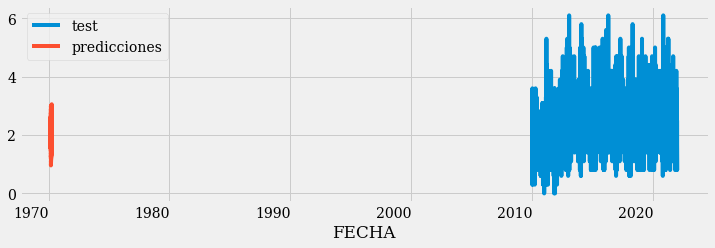

In [35]:
# Gráfico estatico predicciones test
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
df_test['VELMEDIA'].dropna().plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.legend()

In [36]:
import session_info
session_info.show(html=False)

-----
catboost            1.0.4
coloredlogs         15.0.1
joblib              1.0.1
lightgbm            3.3.2
matplotlib          3.4.3
mpl_toolkits        NA
numpy               1.22.1
pandas              1.3.0
plotly              5.5.0
seaborn             0.11.2
session_info        1.0.0
skforecast          0.4.2
sklearn             1.0.2
statsmodels         0.13.1
sty                 NA
xgboost             1.5.2
-----
IPython             7.25.0
jupyter_client      6.1.12
jupyter_core        4.7.1
-----
Python 3.9.6 (tags/v3.9.6:db3ff76, Jun 28 2021, 15:26:21) [MSC v.1929 64 bit (AMD64)]
Windows-10-10.0.19043-SP0
-----
Session information updated at 2022-01-26 17:08
